# Running the spectral graph model using the classes branch. 

Trying out functionality to debug. 

### Import modules

In [1]:
import sys,os
sys.path.append("..")

#SCFC modules
from forward import network_transfer as nt
from utils import functions
from brain import Brain
from read import data_reader as dr
from preprocess import permute as perm 
from utils import path as pth
from preprocess import filters

#generic modules
import matplotlib.pyplot as mpl
%matplotlib inline
import numpy as np
from scipy.signal import lfilter, firls, decimate
import time

### Create an instance of a brain and do basic operations.

In [2]:
mybrain = Brain.Brain()

In [3]:
directory = pth.get_sibling_path('data')

In [4]:
mybrain.add_connectome(directory)

In [5]:
mybrain.connectome.size

7396

In [6]:
mybrain.reorder_connectome(mybrain.connectome, mybrain.distance_matrix)

In [7]:
mybrain.distance_matrix.shape

(86, 86)

In [8]:
vars(mybrain).keys()

dict_keys(['connectome', 'reducedConnectome', 'distance_matrix', 'permutation', 'ordering', 'ntf_params'])

Get the reduced form of the connectome using these mysterious functions. 

In [9]:
mybrain.connectome[0][:3]

array([0.   , 0.125, 3.15 ])

In [10]:
mybrain.bi_symmetric_c()
mybrain.reduce_extreme_dir()

### Running the network transfer model on the brain class

Do the calculation of the NTF for a single frequency.

In [11]:
fq, ev, Vv, freqresp_out, _ = nt.network_transfer_function(mybrain, 
                                                           parameters = mybrain.ntf_params, 
                                                           w=2*np.pi)

OK, as before let's do it for a range of frequencies.

In [12]:
fmin = 2 # 2Hz - 45Hz signal range
fmax = 45
fvec = np.linspace(fmin,fmax,40)

evec = []
Vvec =[]
fqall = []
freq_model = []

start = time.time()
for i in fvec:
    w = 2*np.pi*i
    fq, ev, Vv, freqresp_out, _ = nt.network_transfer_function(mybrain, mybrain.ntf_params, w)
    fqall.append(fq)
    evec.append(ev)
    Vvec.append(Vv)
    freq_model.append(freqresp_out)
    
fqall = np.asarray(fqall)
evec = np.asarray(evec)
Vvec = np.asarray(Vvec)
freq_model = np.asarray(freq_model)
freq_model = np.transpose(freq_model)
stop = time.time()
duration = stop - start

print('Computation time = ', duration)
# np.moveaxis(Vvec,1,0).shape #86x40x57 just like matlab

Computation time =  0.44074201583862305


### Plot magnitudes 

Text(0, 0.5, 'Magnitude (dB)')

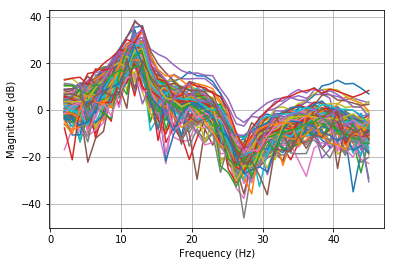

In [13]:
fig = mpl.figure(num=5, figsize = (6,4))
for g in range(len(freq_model)):
    mpl.plot(fvec,functions.mag2db(np.abs(freq_model[g,:])))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')
#mpl.plot(fvec,mag2db(np.abs(freq_model)))

### Adding some real data

Now, we can import some real MEG data, and process it. Let's choose a random file.

In [14]:
filename = directory + '/MEG-chang/8002.101/DK_timecourse_20.h5'

In [15]:
mybrain.add_MEG(filename)

In [16]:
label_path = pth.get_sibling_path('dictionaries')

In [17]:
HCP_order = os.path.join(label_path, 'HCP_list.h5')

In [18]:
mybrain.order_MEG(HCP_order)

In [19]:
datakeys = list(mybrain.MEGdata.keys())

Let's look at the order in the HCP file for comparison.

In [20]:
standardlist = pth.read_hdf5(HCP_order)

In [21]:
i=0
while i < 68:
    if datakeys[i] != standardlist[i]:
        print('Mismatch occurred at ' + str2int(i) + '!')
        i += 1
    else:
        i += 1
    

OK, so the matching seems to work. Let's plot the raw MEG data, so we can compare to the filtering. 

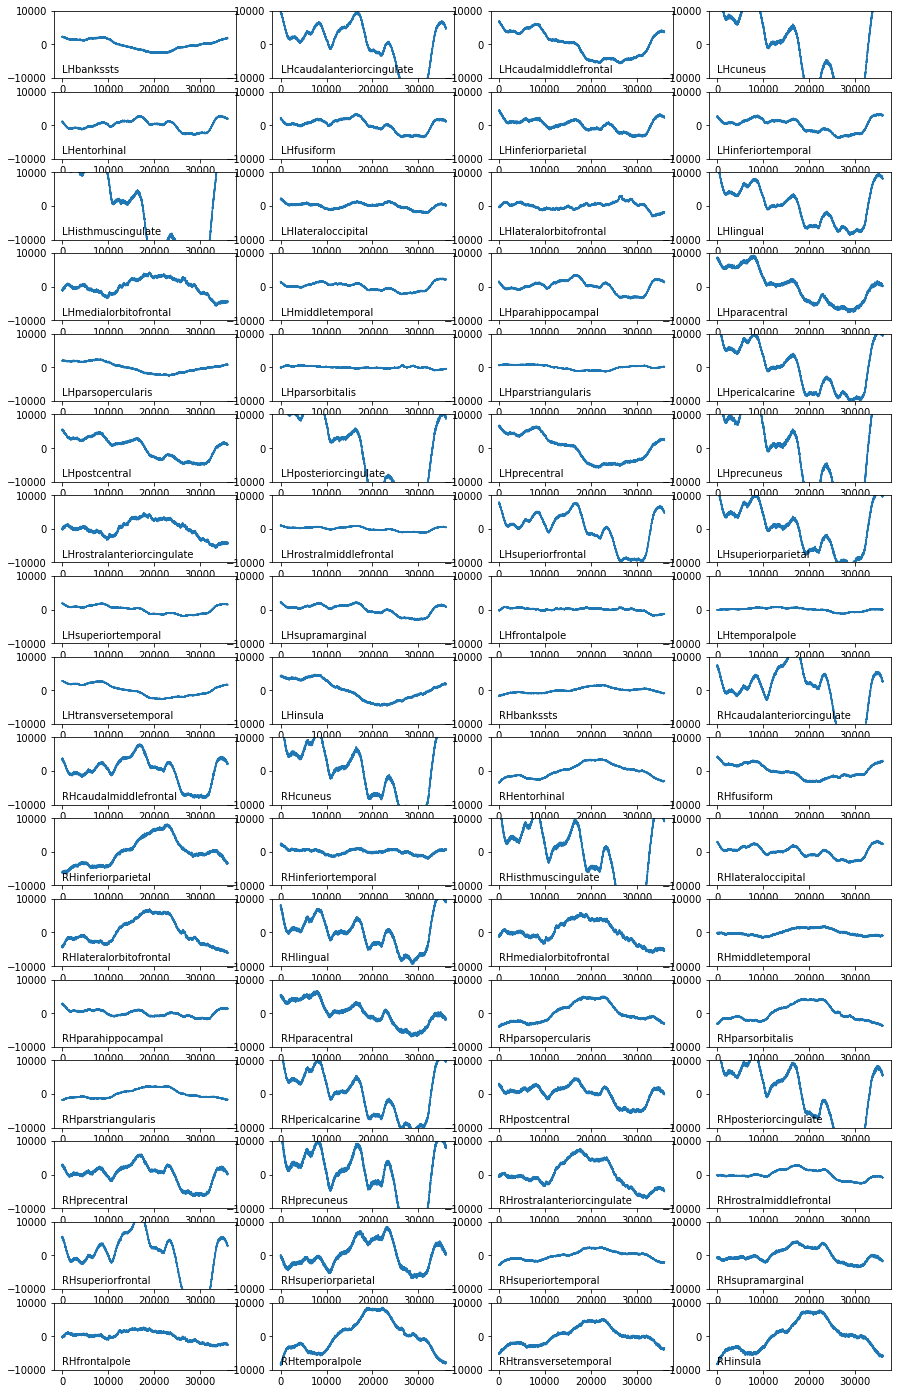

In [22]:
fig1, axes1 = mpl.subplots(17,4,figsize=(15,25))
ax1 = axes1.ravel()
i = 0
for key in list(mybrain.MEGdata.keys()):
    ax1[i].plot(mybrain.MEGdata[key])
    ax1[i].text(0,-8500, key)
    ax1[i].set_ylim([-10000,10000])
    i += 1

OK, we need to apply the filter to this data so we get something a little more like what we would expect. The filter function returns the FFT'ed form (actually we're skipping the function here as it is behaving strangely -- will fix)

In [23]:
fsampling=600
fmin=2
fmax=45
regions =68
fs = fsampling

hbp = firls(101, np.array([0, 0.2*fmin, 0.9*fmin, fmax-2, fmax+5, 100])*2/fs, desired = np.array([0, 0, 1, 1, 0, 0])) #for detrending, a bandpass
lpf = np.array([1, 2, 5, 2, 1])
lpf = lpf/np.sum(lpf)
ind_del = hbp.size 

/Users/pferreira/.virtualenvs/py36-brain/lib/python3.6/site-packages/scipy/linalg/basic.py:1321: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  x, resids, rank, s = lstsq(a, b, cond=cond, check_finite=False)


In [24]:
FMEGdata = {}

In [25]:
MEGdata = mybrain.MEGdata

In [26]:
import nitime.algorithms as tsa

In [27]:
for key in list(MEGdata.keys()):
        data = MEGdata[key]
        data = data.astype(float)
        row = np.asarray(data)
        q = lfilter(hbp, 1, row)
        q = q[ind_del:-1]
        ds_q = decimate(q, 4, axis = 0)
        f, psd, nu = tsa.multi_taper_psd(ds_q, Fs = fs/4, NW = 3, BW = 1, adaptive = False, jackknife = False)
        Fdata = np.convolve(psd, lpf, mode = 'same')
        FMEGdata[key] = Fdata

/Users/pferreira/.virtualenvs/py36-brain/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/pferreira/.virtualenvs/py36-brain/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/pferreira/.virtualenvs/py36-brain/lib/python3.6/site-packages/scipy/signal/signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` i

Let's turn the output in to an array and then take the mean.

In [28]:
length = len(FMEGdata['RHinsula'])
length

4488

In [29]:
FMEGarray = np.zeros((68, length))
i = 0
for key in list(FMEGdata.keys()):
    FMEGarray[i,:] = FMEGdata[key]
    i+=1

In [30]:
meanfiltered = np.mean(FMEGarray, axis = 0)

In [31]:
meanfiltered.shape

(4488,)

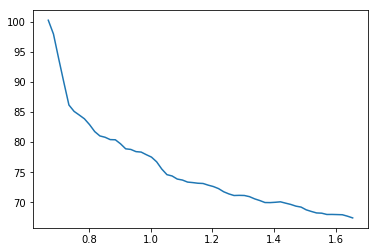

In [32]:
mpl.plot(f[40:100], functions.mag2db(meanfiltered[40:100]))